In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio, display
from scipy import signal

# audio example
samples, fs = librosa.load("audio_examples/voice.wav", sr=44100)

samples = samples[fs:fs*4]

# **Basic Delay Strucutures**

## **FIR Comb Filter**

A FIR comb filter creates a time-delayed copy of an input signal and combines it with the original signal. The filter has two parameters:
- $t$: Time delay
- $g$: Gain (relative amplitude) of the delayed signal

The **difference equation** is:

$\large y(n) = x(n) + gx(n - M)$

where  $\large M = t \cdot f_s$ 

The **transfer function** is:

$\large H(z) = 1 + gz^{-M}$

For positive values of $g$, the frequency response shows periodic peaks at multiples of $1/t$ Hz. The magnitude response oscillates between $1 + g$ and $1 - g$, creating a comb-like pattern of alternating amplification and attenuation.

**Example**

Note that for example below, when M is not an integer, linear interpolation is used between adjacent samples to achieve more accurate fractional delays.


In [2]:

def fir_comb_filter(x, t, g, fs):
    N = len(x)
    y = np.zeros(N)
    M = int(t * fs)
    frac =  (t * fs) - M
    
    for n in range(N):
        if n < M:
            y[n] = x[n]
            continue

        y[n] = x[n] + g * x[n - M]

        # interpolate with we have floating point M
        if frac != 0 and n > M:
            y[n] *= (1 - frac) + x[n - M -1] * frac
            
    return y

def fir_comb_filter_freq_response(t, g ,fs, n_points=1024):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)
    M = int(t * fs)

    for i, omega in enumerate(w):
        z = np.exp(1j * omega)

        H[i] = 1 + g * z**-M

    freqs = (w * fs) / (np.pi * 2)

    # return in mag db for convinience
    return freqs, 20 * np.log10(np.abs(H))


gs = [0.8, -0.8]
ts = [0.05,  0.05]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(16, 4))

for g, t, color in zip(gs, ts, colors):
    freqs, mags = fir_comb_filter_freq_response(t, g, fs)
    plt.plot(freqs, mags, color=color, label=f"g={g}, t={t}")

plt.xscale('log')
plt.xlim(20, fs / 2)  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title(f"FIR Comb Filter")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

neg_delyed = fir_comb_filter(samples, ts[1], gs[1], fs)

for g, t in zip(gs, ts):
    print(f"delayed g={g} , t={t}")
    delayed = fir_comb_filter(samples, t, g, fs)
    display(Audio(delayed, rate=fs))
    


delayed g=0.8 , t=0.05


delayed g=-0.8 , t=0.05


## **IIR Comb Filter**

IIR Comb Filter
An IIR comb filter creates an infinite series of delayed copies of the input signal through feedback. Each delayed copy is attenuated by gain factor $g$, simulating multiple reflections. The filter has three parameters:

- $t$: Time delay (in seconds)
- $g$: Feedback gain ($|g| < 1$ for stability)
- $c$: Input gain (typically set to $1-g$ for unity gain at DC)

The difference equation is:

$\large y(n) = c \cdot x(n) + g \cdot y(n-M)$

where $\large M = t \cdot f_s$ (samples)

The transfer function is:

$\large H(z) = \frac{c}{\Large 1 - gz^{-M}}$

**Example**

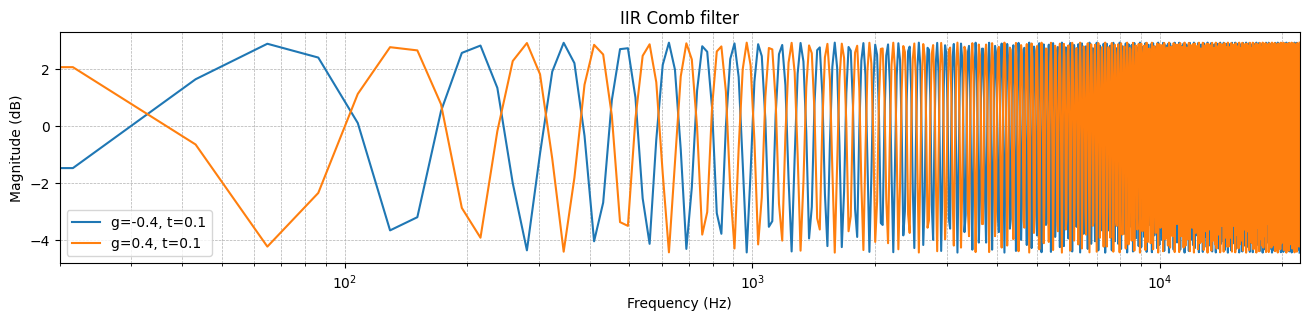

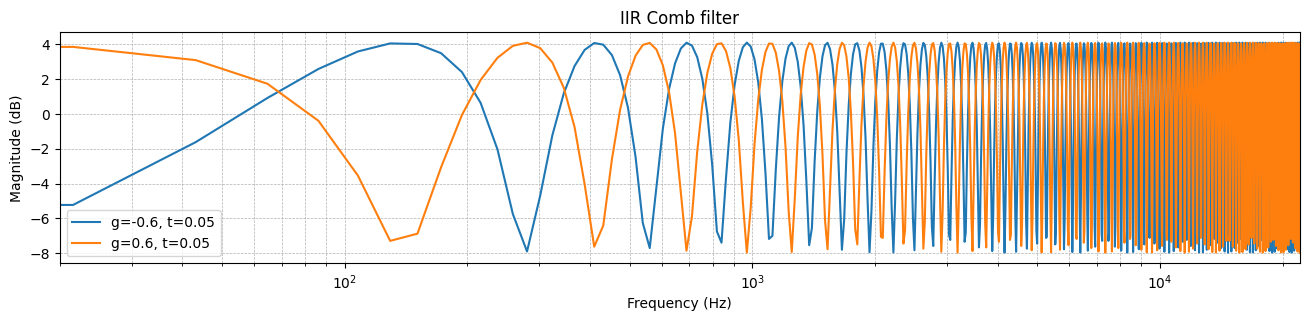

Delayed g=-0.4, t=0.1


Delayed g=0.4, t=0.1


Delayed g=-0.6, t=0.05


Delayed g=0.6, t=0.05


In [3]:

def iir_comb_filter(x, g, t, fs):
    N = len(x)
    
    y = np.zeros(N)
    c = 1 - g # unit gain
    M = int(t * fs)
    # for interpolation in case M is fractional
    frac =  (t * fs) - M

    for n in range(N):
        if M > n:
            y[n] = c * x[n]
            continue
            
        y[n] = c * x[n] + g * y[n - M]

        if frac != 0 and n > M:
            y[n] *= (1 - frac) + y[n - M - 1] * frac

    return y

gs = [-0.4, 0.4, -0.6 , 0.6]
ts = [0.1, 0.1, 0.05, 0.05 ]

def iir_comb_filter_freq_response(g, t, fs, n_points=1024):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)
    
    c = 1 - g # unit gain

    for i, omega in enumerate(w):
        z = np.exp(1j - omega)

        H[i] = c / (1 - g * z**-1)

    freqs = (w * fs) / (np.pi * 2)

    return freqs, 20 * np.log10(np.abs(H))

plt.figure(figsize=(16, 3))

def show_plot():
    plt.xscale('log')
    plt.xlim(20, fs / 2)  
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(f"IIR Comb filter")
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()


for g, t, color in zip(gs[:2], ts[:2], colors):
    freqs, mags = fir_comb_filter_freq_response(t, g, fs)
    plt.plot(freqs, mags, color=color, label=f"g={g}, t={t}")

show_plot()


plt.figure(figsize=(16, 3))

for g, t, color in zip(gs[2:], ts[2:], colors):
    freqs, mags = fir_comb_filter_freq_response(t, g, fs)
    plt.plot(freqs, mags, color=color, label=f"g={g}, t={t}")


show_plot()


for g, t in zip(gs, ts):
    print(f"Delayed g={g}, t={t}")
    delayed = iir_comb_filter(samples, g, t, fs)
    display(Audio(delayed, rate=fs))


## **Universal Comb Filter**

<img src="diagrams/universal_combfilter.png" width="70%">

The universal comb filter combines the properties of FIR (Finite Impulse Response) and IIR (Infinite Impulse Response) comb filters into a single versatile structure. A key characteristic of this filter is the use of an M-sample delay operator $z^{-M}$, which replaces the single-sample delay operator $z^{-1}$ found in basic digital filters. This M-sample delay creates the characteristic "comb" shape in the frequency response, with M determining the spacing between the peaks and notches.

The architecture can implement various filter types through three main parameters:
- Blend parameter (**BL**): Controls the mix of the direct and delayed signals
- Feedback coefficient (**FB**): Controls the recursive feedback component
- Feedforward coefficient (**FF**): Controls the direct path gain

The structure reduces to specific filter types based on parameter settings:

|Filter Type|BL|FB|FF|Description|
|-----------|--|--|--|-----------|
|FIR Comb|1|0|g|Feedforward M-sample delay with gain|
|IIR Comb|c|g|0|Recursive filter with M-sample feedback|
|Allpass|a|-a|1|All frequencies passed with phase shift, special case where -BL = FB|
|Pure Delay|0|0|1|Simple M-sample delay|

Of particular interest is the allpass configuration (when -BL = FB and FB = 1), which maintains unity gain across all frequencies while introducing frequency-dependent phase shifts based on the M-sample delay.

### **Transfer Function**

$H(z) = \Large\frac{BL + FF·z^{-M}}{1 - FB·z^{-M}}$



### **Difference Equation**
The universal comb filter is described by two equations:

$y(n) = FF \cdot x_h(n-M) + BL \cdot x_h(n)$

where $x_h(n) = x(n) + FB \cdot x_h(n-M)$

Here, $M$ represents the delay length in samples ,$\large M = t \cdot f_s$,  which determines the fundamental frequency of the comb filter.

**Example**

Below, we have a universal implementation for the delay that can implement the different delays as shown in the table above.

FIR


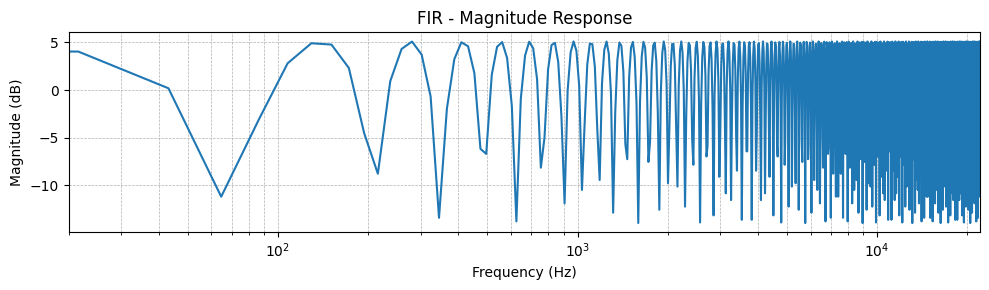

IIR


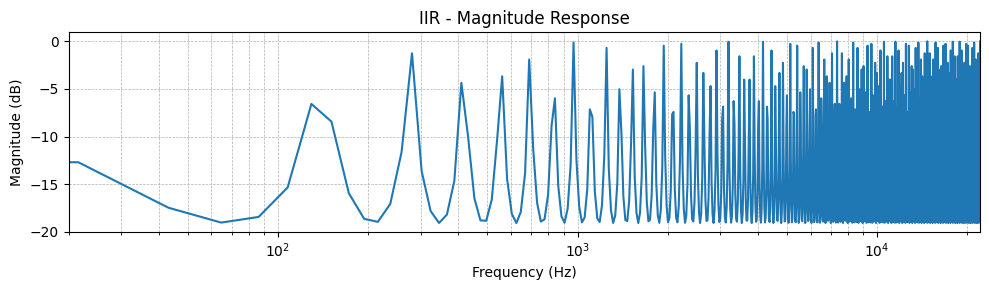

Allpass


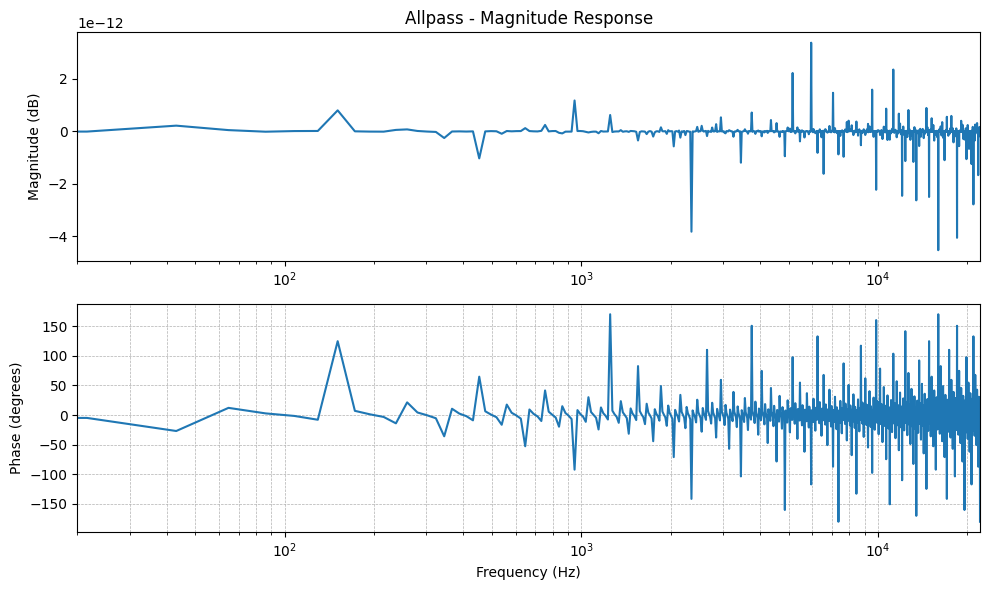

Pure Delay (sounds the same)


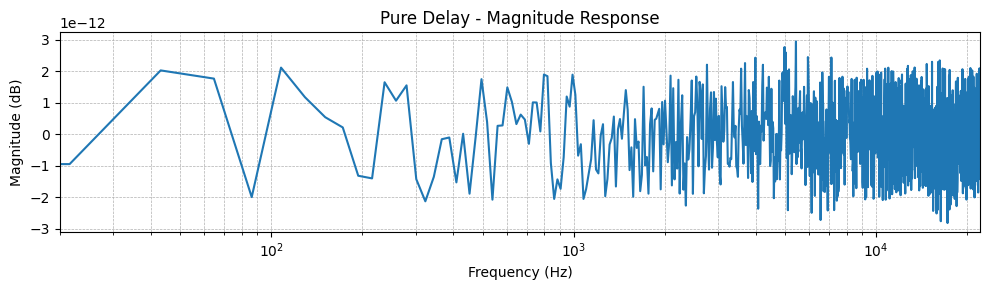

In [4]:

# could make len(x_h) == len(x) to simplify the calculation and use same indexing (n - M) as difference equation
# but optimizing a bit with the delay_line to experiment
def universal_delay(x, BL, FB, FF, M):
    N = len(x)
    y = np.zeros(N)
    delay_line = np.zeros(M)
    
    for n in range(N):
        if n < M:
            # being explicity with x(n-M) = 0
            x_h = x[n] + FB * 0
            y[n] = FF * 0 + BL * x_h
            delay_line[n] = x_h
            continue
            
        i = (n - M) % M
        x_h = x[n] + FB * delay_line[i]
        y[n] = FF * delay_line[i] + BL * x_h
        
        delay_line[n % M] = x_h

    return y

def universal_delay_freq_response(BL, FB, FF, M):
    w = np.linspace(0, np.pi, 1024)
    H = np.zeros_like(w, dtype=complex)

    for i, omega in enumerate(w):
        z = np.exp(1j * omega)
        H[i] = (BL + FF * z**-M) / (1 - FB * z**-M)

    freqs = (w * fs) / (np.pi * 2)
    phase = np.angle(H, deg=True)
    
    return freqs, 20 * np.log10(np.abs(H)), phase
    

def fir_comb(x, g, t, fs):
    BL = 1
    FB = 0
    FF = g
    M = int(t * fs)

    freqs, H, _ = universal_delay_freq_response(BL, FB, FF, M)

    return universal_delay(x, BL,FB, FF, M), freqs, H

def iir_comb(x, g, t, fs):
    c = 1 - g # for unit gain
    BL = c
    FB = g
    FF = 0
    M = int(t * fs)
    
    freqs, H, _ = universal_delay_freq_response(BL, FB, FF, M)
    
    return universal_delay(x, BL,FB, FF, M), freqs, H


# a will control how much phase shift, and t the delay time
def allpass(x, a, t, fs):
    BL = a
    FB = -a  
    FF = 1
    M = int(t * fs)
    
    freqs, H, phase = universal_delay_freq_response(BL, FB, FF, M)

    return universal_delay(x, BL, FB, FF, M), freqs, H, phase

def pure_delay(x, t, fs):
    BL = 0
    FB = 0
    FF = 1
    M = int(t * fs)

    freqs, H, _ = universal_delay_freq_response(BL, FB, FF, M)
    
    return universal_delay(x, BL, FB, FF, M), freqs, H

# Display the phase for allpass for vizualization
def show_plot(title, freqs, mags, phase=None):
    if phase is None:
        plt.figure(figsize=(10, 3))
        plt.plot(freqs, mags)
        plt.xscale('log')
        plt.xlim(20, fs / 2)  
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (dB)")
        plt.title(f"{title} - Magnitude Response")
    else:
        plt.figure(figsize=(10, 6))
        plt.subplot(211)
        plt.plot(freqs, mags)
        plt.xscale('log')
        plt.xlim(20, fs / 2)  
        plt.ylabel("Magnitude (dB)")
        plt.title(f"{title} - Magnitude Response")
        
        plt.subplot(212)
        plt.plot(freqs, phase)
        plt.xscale('log')
        plt.xlim(20, fs / 2)
        plt.ylabel("Phase (degrees)")
        plt.xlabel("Frequency (Hz)")
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()

       
print("FIR")
fir, freqs, mags = fir_comb(samples, 0.8, 0.1, fs)
display(Audio(fir, rate=fs))
show_plot("FIR", freqs, mags)

print("IIR")
iir, freqs, mags = iir_comb(samples, 0.8, 0.1, fs)
display(Audio(iir, rate=fs))
show_plot("IIR", freqs, mags)


# short t otherwise we don't hear it as phase shift
ap,freqs, mags, phase = allpass(samples, 0.9, 0.01, fs)
print("Allpass")
display(Audio(ap, rate=fs))
show_plot("Allpass", freqs, mags, phase)

# just delays the signal by some amount
print("Pure Delay (sounds the same)")
delay, freqs, mags = pure_delay(samples, 0.1, fs)
display(Audio(delay, rate=fs))
show_plot("Pure Delay", freqs, mags)


## **Paralell Delay Network**

<img src="diagrams/universal_parallel_combfilter.png" width="80%">

The universal comb filter structure can be extended to a parallel network of multiple delay lines, creating more complex and rich audio effects. In this configuration:

- The system consists of N parallel delay lines with different delay times ($z^{-M}$, $z^{-0}$ , $z^{-P}$, $z^{-Q}$, ...)
- The coefficients BL (blend), FB (feedback), and FF (feedforward) are now N×N matrices
- These matrices control how signals are mixed between different delay lines
- The N×N matrices enable cross-coupling between delay lines, creating more complex echo patterns

Common applications include:

|Effect|Delay Times|BL|FB|FF|Description|
|-----|-----------|--|--|--|-----------|
|Slapback|~50ms|Identity|0|Diagonal|Simple echo with no feedback|
|Echo|>50ms|Identity|Diagonal|0|Classic delay with feedback|
|Reverb|Various|Identity|Dense|Dense|Complex feedback network simulating room reflections|

Where:
- Identity matrix for BL allows direct signal path
- Diagonal matrices create independent delays
- Dense matrices create cross-coupling between delays


### **Difference Equation**

$ x_h(n) = x(n) \cdot 1 + FB \cdot x_h(n-M) $

$ y(n) = 1^T \cdot [FF \cdot x_h(n-M) + BL \cdot x_h(n)] $


where:
- 1 is an N-dimensional vector of ones
- xₕ(n-M) represents the vector of delayed states
- 1^T is the transpose of 1, summing all channels to scalar output


### **Transfer Function**

$H(z) = \Large\frac{1^T \cdot [BL + FF \cdot Z^{-M}] \cdot 1}{1^T \cdot [I - FB \cdot Z^{-M}] \cdot 1}$

Where:

- $Z^{-M}$ is the diagonal matrix of delays
- $I$ is the identity matrix
- $1$ is the vector of ones
- $1^T$ is its transpose



In [74]:
def parallel_delay_network(x, ts, BL, FB, FF, fs):
    """
    Parameters:
    x: input signal
    ts: list of delay times in seconds
    BL, FB, FF: NxN matrices for blend, feedback, and feedforward
    fs: sampling rate
    """

    n_delays = len(ts)
    N = len(x)
    
    delays_in_samples = [int(t * fs) for t in ts]
    max_delay = np.max(delays_in_samples)
    
    # State Matrix: N-Delay lines x signal length
    x_h = np.zeros((n_delays, N + max_delay)) 
    y = np.zeros(N)

    for n in range(N):
        # Get delayed x_h values for each delay line
        delayed_xh = np.zeros(n_delays)
        for i in range(n_delays):
            M_i = delays_in_samples[i]
            delayed_index = n - M_i + max_delay
            
            if delayed_index >= 0:
                delayed_xh[i] = x_h[i, delayed_index]
            else:
                delayed_xh[i] = 0.0
        
        xh = x[n] + FB @ delayed_xh
        x_h[:, n + max_delay] = xh  
        
        y[n] = np.sum(FF @ delayed_xh + BL @ xh)
        
    return y


# example implementationa
# Slack back with 3 delays
def slap_back(x, fs):
    n_delay_lines = 3
    delays = [0.25, 0.50, 0.75 ] # 3 lines

    BL = np.eye(n_delay_lines)
    FB = np.zeros((n_delay_lines, n_delay_lines))
    FF = np.diag([0.5, 0.25, 0.125]) # 3 lines

    return parallel_delay_network(x, delays, BL, FB, FF, fs)

s = slap_back(samples, fs)
display(Audio(s, rate=fs))

def reverb(x, fs):
    n_delays = 50
    
    delays = np.linspace(0.04, 0.4, n_delays)
    
    BL = np.eye(n_delays) * 0.2  # Some direct signal
    FB = np.eye(n_delays) * 0.4  # Medium feedback
    
    gains = 0.7    ** np.arange(n_delays)
    FF = np.diag(gains)
    
    return parallel_delay_network(x, delays, BL, FB, FF, fs)

# Test it
r = reverb(samples, fs)
display(Audio(r, rate=fs))
    


In [6]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [8]:
np.diag([0.7, 0.5])

array([[0.7, 0. ],
       [0. , 0.5]])